In [1]:
!git clone https://github.com/RIPS-2024-Aerospace/Aerospace-Project.git

Cloning into 'Aerospace-Project'...
remote: Enumerating objects: 539, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 539 (delta 170), reused 218 (delta 131), pack-reused 269 (from 1)
Receiving objects: 100% (539/539), 34.52 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (260/260), done.


In [2]:

!pip install simanneal

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import random
from simanneal import Annealer
from sklearn.decomposition import PCA

np.random.seed(29)

%run "/content/Aerospace-Project/DiffusionLunarKF.ipynb"
%run "/content/Aerospace-Project/CentralizedLunarKF.ipynb"
%run "/content/Aerospace-Project/FilterComparison.ipynb"

In [6]:
C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])

n = len(C)

true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
# true_drifts = np.array([[0 for _ in range(n)]]).T

F = np.array([[1,dt],[0,1]])
F_full = np.kron(np.eye(n),F)

def get_station_truth(x,id):
    return np.array([[x[2*id][0]],[x[2*id+1][0]]])

x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

# random initial estimates for each node

x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
x0_cf = np.vstack(tuple(x0))
# x0 = [np.array([[0],[0]]) for _ in range(n)]

P = [100*np.copy(R(1)) for _ in range(n)]
P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

stations = [Station(i) for i in range(n)]

filter_initialize(stations,D,x0,P)

Q_10x10 = np.kron(np.eye(5),Q)

kf = KalmanFilter(A = F_full, H = H_cf, Q = Q_10x10, R = R_cf, P = P_prev, x0 = x0_cf)
#For the first iteration these are our cross_links
iterations = 150

# num_msmts = np.random.randint(0,10,(iterations,5))
num_msmts = np.array([[1,6,6,6,6] for _ in range(iterations)])

filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,kf, x)

errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements,predictions_cf,predictions_df = filter_outputs


Monte Carlo to find the Covariance if the filter \\
Details: 10 iters of monte carlo \\
150 iters of the filter


In [7]:
# defined if function is placed in seperate file
import numpy as np
import math

def sample_cov_and_mean(C):
    sample_cov = 0
    sample_mean = 0
    iters = 10 # monte carlo iters
    for j in range(iters):
      # Variables
      T_c = 0.00000009775
      f_L1 = 1575420000
      N_i = 4
      CN0 = 15
      B_pll = 0.5
      B_fe = 26000000
      T = 0.020
      d = 0.3
      pi = math.pi
      c = 299792458
      B_dll = 0.5
      dt = 7
      sigma_uere = 0 # can't find a value for this

      # Values from random table in Source 31
      # h_0 = 1.4*(10**(-22))
      # h_m1 = 2.3*(10**(-26))
      # h_m2 = 3.3*(10**(-31))

      # Values from sample clocks in Source 30
      h_0 = 1.8*(10**(-21))
      h_m1 = 6.492*(10**(-22))
      h_m2 = 1.37*(10**(-24))

      e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*h_m2*(pi**2)*(dt**3)
      e2 = 2*h_m1*dt + h_m2*((pi*dt)**2)
      e3 = ((h_0/(2*dt))+ 2*h_m1 + (8/3)*(pi*pi)*h_m2*dt)

      Q = (c**2)*np.array([[e1,e2],[e2,e3]])

      s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
      pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

      s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
      prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)

      R = lambda N : np.kron(np.eye(N),np.array([[pr_var,0],[0,prr_var]]))
      R_cf = lambda num_msmts: np.kron(np.eye(sum(num_msmts)),R(1))

      measure_noise = lambda num_msmts : np.linalg.cholesky(R_cf(num_msmts)) @ np.random.normal(np.array([[0 for _ in range(2*sum(num_msmts))]]).T)
      sigma_j = 10**(-16)

      # C = np.array([[0.3,0,0.2,0.5,0], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
      D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])

      n = len(C)

      true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
      true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
      # true_drifts = np.array([[0 for _ in range(n)]]).T

      F = np.array([[1,dt],[0,1]])
      F_full = np.kron(np.eye(n),F)

      Q_10x10=np.kron(np.eye(5), Q)

      def get_station_truth(x,id):
        return np.array([[x[2*id][0]],[x[2*id+1][0]]])

      x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

      # Random initial estimates for each node
      x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
      x0_cf = np.vstack(tuple(x0))
      # x0 = [np.array([[0],[0]]) for _ in range(n)]

      P = [100*np.copy(R(1)) for _ in range(n)]
      P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

      stations = [Station(i) for i in range(n)]

      filter_initialize(stations,D,x0,P)

      kf = KalmanFilter(A = F_full, H = H_cf, Q = Q_10x10, R = R_cf, P = P_prev, x0 = x0_cf)
      # For the first iteration these are our cross_links
      iterations = 150

      # num_msmts = np.random.randint(0,10,(iterations,5))
      num_msmts = np.array([[1,6,6,6,6] for _ in range(iterations)])

      filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,kf, x)

      errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements,predictions_cf,predictions_df = filter_outputs

      # expectation of full state covariance (without normalizing)
      errors_flat = errors_df[-1].flatten()
      e = np.outer(errors_flat, errors_flat)
      sample_cov = sample_cov + e

      # expectation of errors
      sample_mean = sample_mean + errors_flat



    sample_cov = sample_cov / iters
    sample_mean = sample_mean / iters

    return sample_mean, sample_cov, P_hist_cf[-1]

# # Example usage
# C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
# sample_mean, sample_cov, P_cf = sample_cov_and_mean(C)




PCA visualization of Bhattacharya distance using only 2 components but 100 steps of annealing

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best weights matrix:
[[0.         0.         0.07110876 0.37244823 0.55644301]
 [0.         1.         0.         0.         0.        ]
 [0.02632217 0.         0.97367783 0.         0.        ]
 [0.05761709 0.         0.         0.94238291 0.        ]
 [0.         0.         0.         0.         1.        ]]
Row sums: [1. 1. 1. 1. 1.]
Best Bhattacharyya distance: 2.2863439703199866


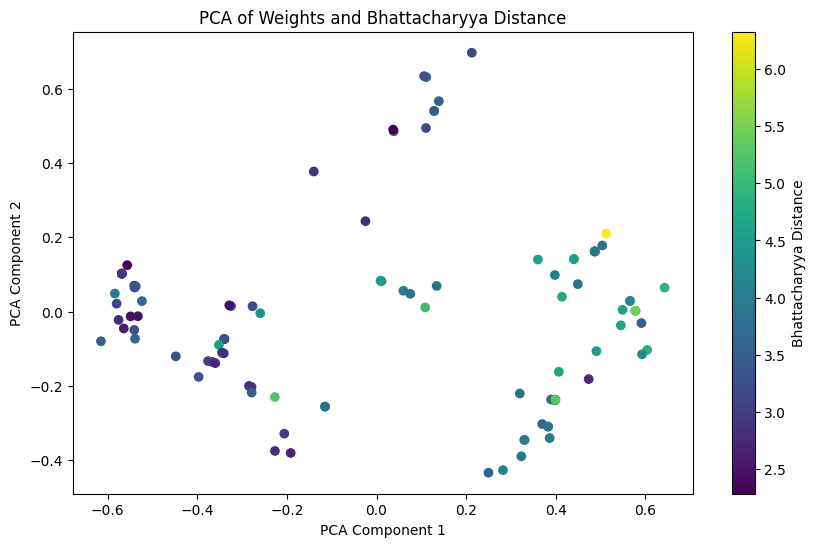

In [8]:


# Define Bhattacharyya Distance
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    term1 = 0.125 * np.dot((mu1 - mu2).T, np.linalg.inv((Sigma1 + Sigma2) / 2)).dot(mu1 - mu2)
    term2 = 0.5 * np.log(np.linalg.det((Sigma1 + Sigma2) / 2) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))
    return term1 + term2

# Define the cost function for optimization
def cost_func(diffusion_weights):
    # Convert the flattened diffusion_weights back to the 2D matrix form
    C = np.reshape(diffusion_weights, (5, 5))  # Assuming a 5x5 matrix for C

    # Pass the updated C matrix to the sample_cov_and_mean function
    dkf_mean, dkf_cov, kf_cov = sample_cov_and_mean(C)

    mu_kf = np.zeros(dkf_mean.shape)  # Mean of KF
    mu_df = dkf_mean  # Mean of DF
    Sigma_kf = kf_cov  # Covariance of KF
    Sigma_df = dkf_cov  # Covariance of DF

    return bhattacharyya_distance(mu_kf, mu_df, Sigma_kf, Sigma_df)

# Simulated Annealing class for optimization
class AnnealOptimization(Annealer):
    def __init__(self, state, C_adj):
        super(AnnealOptimization, self).__init__(state)
        self.steps = 100
        self.C_adj = C_adj
        self.path = []  # To store the states and corresponding Bhattacharyya distances

    def move(self):
        # Randomly modify one of the weights corresponding to a non-zero element in self.C_adj
        idx = np.random.choice(np.where(self.C_adj.flatten() == 1)[0])
        self.state[idx] += np.random.normal(0, 0.5)

        # Constraint: weights must be non-negative
        self.state[self.state < 0] = 0

        # Constraint: row stochasticity for non-zero elements
        for i in range(0, len(self.state), 5):
            row = self.state[i:i + 5] * self.C_adj[i // 5]
            row_sum = np.sum(row)
            if row_sum != 0:
                self.state[i:i + 5] = (row / row_sum) * self.C_adj[i // 5]

    def energy(self):
        energy = cost_func(self.state)
        self.path.append((self.state.copy(), energy))  # Record the state and its energy
        return energy

def visualize_pca(path):
    # Extract the weights and Bhattacharyya distances from the path
    weights = np.array([p[0] for p in path])
    distances = np.array([p[1] for p in path])

    # Determine the number of components based on the data shape
    n_components = min(weights.shape[0], weights.shape[1], 2)

    if n_components < 2:
        print("Not enough data points for 2D PCA. Skipping PCA visualization.")
        return

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    weights_pca = pca.fit_transform(weights)

    # Plot the PCA components
    plt.figure(figsize=(10, 6))
    plt.scatter(weights_pca[:, 0], weights_pca[:, 1], c=distances, cmap='viridis')
    plt.colorbar(label='Bhattacharyya Distance')
    plt.title('PCA of Weights and Bhattacharyya Distance')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Run the optimization
def run_optimize():
    C = np.array([
        [0.2, 0.2, 0.2, 0.2, 0.2],
        [0.1, 0.9, 0., 0., 0.],
        [0.1, 0., 0.9, 0., 0.],
        [0.1, 0., 0., 0.9, 0.],
        [0.1, 0., 0., 0., 0.9]
    ])

    # Adjacency matrix indicating possible connections (1 if there is a connection, 0 otherwise)
    C_adj = np.array([[1, 1, 1, 1, 1],
                      [1, 1, 0, 0, 0],
                      [1, 0, 1, 0, 0],
                      [1, 0, 0, 1, 0],
                      [1, 0, 0, 0, 1]])

    # Flatten C matrix to use as initial weights
    weights = C.flatten()

    # Initialize simulated annealing optimization
    annealer = AnnealOptimization(weights, C_adj)
    best_state, best_energy = annealer.anneal()

    # Convert the best state back to the matrix form
    best_weights_matrix = np.reshape(best_state, (5, 5))

    # Check if each row in the final best weights matrix sums to 1
    row_sums = np.sum(best_weights_matrix, axis=1)
    print(f'Best weights matrix:\n{best_weights_matrix}')
    print(f'Row sums: {row_sums}')
    print(f'Best Bhattacharyya distance: {best_energy}')

    # Visualize the PCA of weights and Bhattacharyya distances
    visualize_pca(annealer.path)

run_optimize()


PCA visualization of Bhattacharya distance with 3 components and 50 steps of annealing

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Best weights matrix:
[[0.25       0.         0.25       0.25       0.25      ]
 [0.24503439 0.75496561 0.         0.         0.        ]
 [0.39142208 0.         0.60857792 0.         0.        ]
 [0.1        0.         0.         0.9        0.        ]
 [0.         0.         0.         0.         1.        ]]
Row sums: [1. 1. 1. 1. 1.]
Best Bhattacharyya distance: 2.892322266928024


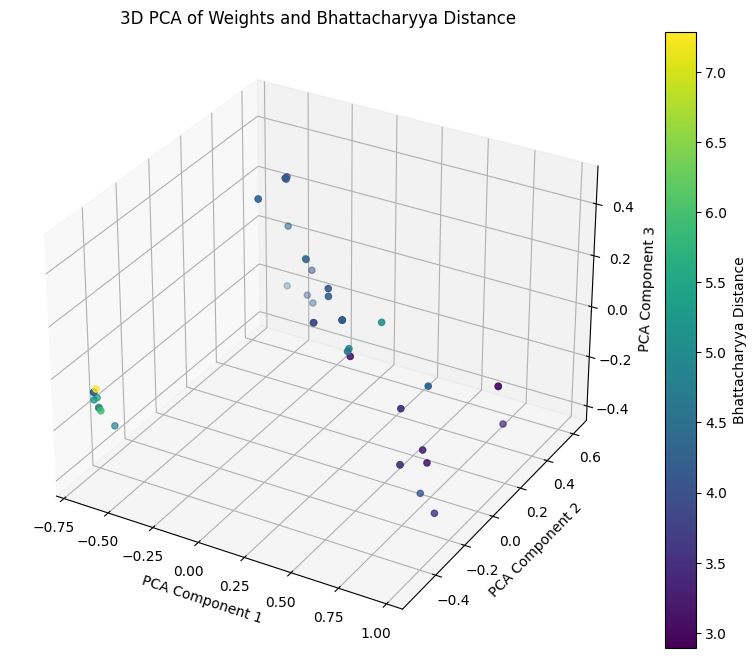

In [9]:


# Define Bhattacharyya Distance
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    term1 = 0.125 * np.dot((mu1 - mu2).T, np.linalg.inv((Sigma1 + Sigma2) / 2)).dot(mu1 - mu2)
    term2 = 0.5 * np.log(np.linalg.det((Sigma1 + Sigma2) / 2) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))
    return term1 + term2

# Define the cost function for optimization
def cost_func(diffusion_weights):
    # Convert the flattened diffusion_weights back to the 2D matrix form
    C = np.reshape(diffusion_weights, (5, 5))  # Assuming a 5x5 matrix for C

    # Pass the updated C matrix to the sample_cov_and_mean function
    dkf_mean, dkf_cov, kf_cov = sample_cov_and_mean(C)

    mu_kf = np.zeros(dkf_mean.shape)  # Mean of KF
    mu_df = dkf_mean  # Mean of DF
    Sigma_kf = kf_cov  # Covariance of KF
    Sigma_df = dkf_cov  # Covariance of DF

    return bhattacharyya_distance(mu_kf, mu_df, Sigma_kf, Sigma_df)

# Simulated Annealing class for optimization
class AnnealOptimization(Annealer):
    def __init__(self, state, C_adj):
        super(AnnealOptimization, self).__init__(state)
        self.steps = 50
        self.C_adj = C_adj
        self.path = []  # To store the states and corresponding Bhattacharyya distances

    def move(self):
        # Randomly modify one of the weights corresponding to a non-zero element in self.C_adj
        idx = np.random.choice(np.where(self.C_adj.flatten() == 1)[0])
        self.state[idx] += np.random.normal(0, 0.5)

        # Constraint: weights must be non-negative
        self.state[self.state < 0] = 0

        # Constraint: row stochasticity for non-zero elements
        for i in range(0, len(self.state), 5):
            row = self.state[i:i + 5] * self.C_adj[i // 5]
            row_sum = np.sum(row)
            if row_sum != 0:
                self.state[i:i + 5] = (row / row_sum) * self.C_adj[i // 5]

    def energy(self):
        energy = cost_func(self.state)
        self.path.append((self.state.copy(), energy))  # Record the state and its energy
        return energy

def visualize_pca(path):
    # Extract the weights and Bhattacharyya distances from the path
    weights = np.array([p[0] for p in path])
    distances = np.array([p[1] for p in path])

    # Determine the number of components based on the data shape
    n_components = min(weights.shape[0], weights.shape[1], 3)

    if n_components < 3:
        print("Not enough data points for 3D PCA. Skipping PCA visualization.")
        return

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    weights_pca = pca.fit_transform(weights)

    # Plot the PCA components
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(weights_pca[:, 0], weights_pca[:, 1], weights_pca[:, 2], c=distances, cmap='viridis')
    plt.colorbar(sc, label='Bhattacharyya Distance')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('3D PCA of Weights and Bhattacharyya Distance')
    plt.show()

# Run the optimization
def run_optimize():
    C = np.array([
        [0.2, 0.2, 0.2, 0.2, 0.2],
        [0.1, 0.9, 0., 0., 0.],
        [0.1, 0., 0.9, 0., 0.],
        [0.1, 0., 0., 0.9, 0.],
        [0.1, 0., 0., 0., 0.9]
    ])

    # Adjacency matrix indicating possible connections (1 if there is a connection, 0 otherwise)
    C_adj = np.array([[1, 1, 1, 1, 1],
                      [1, 1, 0, 0, 0],
                      [1, 0, 1, 0, 0],
                      [1, 0, 0, 1, 0],
                      [1, 0, 0, 0, 1]])

    # Flatten C matrix to use as initial weights
    weights = C.flatten()

    # Initialize simulated annealing optimization
    annealer = AnnealOptimization(weights, C_adj)
    best_state, best_energy = annealer.anneal()

    # Convert the best state back to the matrix form
    best_weights_matrix = np.reshape(best_state, (5, 5))

    # Check if each row in the final best weights matrix sums to 1
    row_sums = np.sum(best_weights_matrix, axis=1)
    print(f'Best weights matrix:\n{best_weights_matrix}')
    print(f'Row sums: {row_sums}')
    print(f'Best Bhattacharyya distance: {best_energy}')

    # Visualize the PCA of weights and Bhattacharyya distances
    visualize_pca(annealer.path)

run_optimize()
